In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sns.set_context('poster', font_scale=1.25)

We are solving

$$\frac{df}{dt}=-(\vec{v}\cdot \nabla)f + D \nabla^2 f + sf(1-f)$$

In [5]:
from adr_2d.solver import Solver

In [6]:
sol = Solver()

So how do we define A? let's start there. We need to define my logical index function.

In [7]:
sol.get_logical_index(5, 5)

505

# Old stuff

Create the 1d grid to start.

In [37]:
import scipy as sp

In [38]:
fi = np.zeros(jmax, dtype=np.double)
fi = sp.stats.norm(loc=dx*jmax/2, scale=10*dx).pdf(xgrid)
fi = np.array([fi]).T

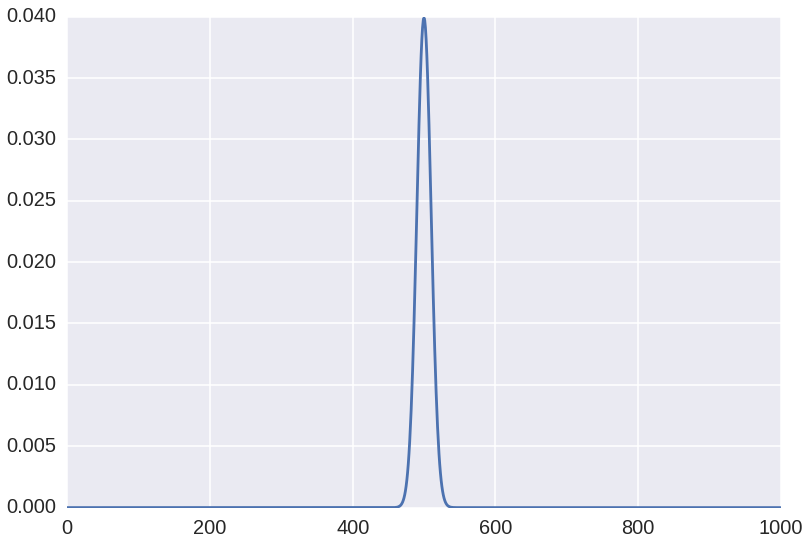

In [19]:
plt.plot(xgrid, fi)

Now to step this forwards.

In [20]:
# Define the advection operator

A = np.zeros((jmax, jmax), dtype=np.double)
for r in range(A.shape[0]):
    for c in range(A.shape[1]):
        to_the_right = (c+1)%A.shape[1]
        to_the_left = (c-1)%A.shape[1]
        if r == to_the_right:
            A[r, c] = -v[r]/(2*dx)
        elif r == to_the_left:
            A[r,c] = v[r]/(2*dx)

In [21]:
# Define the diffusion operator

zeta = np.zeros((jmax, jmax), dtype=np.double)
for r in range(zeta.shape[0]):
    for c in range(zeta.shape[1]):
        to_the_right = (c+1)%zeta.shape[1]
        to_the_left = (c-1)%zeta.shape[1]
        if r == to_the_right:
            zeta[r, c] = D/dx**2
        elif r == to_the_left:
            zeta[r,c] = D/dx**2
        elif r == c:
            zeta[r, c] = -2*D/dx**2

In [22]:
# Define the annoying reaction/growth operator

def G(f):
    return s*f*(1-f)

We now implement the solution.

In [23]:
# Define the identity operator
I = np.identity(jmax, dtype=np.double)

In [24]:
fi_original = fi.copy()

This currently takes too long, so I'm gonna cythonize it.

In [25]:
%load_ext cython

In [30]:
sol_in_time = np.zeros((jmax, imax), dtype=np.double)

fi = fi_original.copy()
sol_in_time[:, 0] =  fi[:, 0]

for i in range(imax):
    inv = np.linalg.inv(I - (dt/2.)*zeta)
    propagation = (I + dt*A + (dt/2.)*zeta).dot(fi)
    growth = dt*s*fi*(1-fi)
    
    fi_plus_1 = inv.dot(propagation + growth)
    sol_in_time[:, i] = fi_plus_1[:, 0]
    
    fi = fi_plus_1

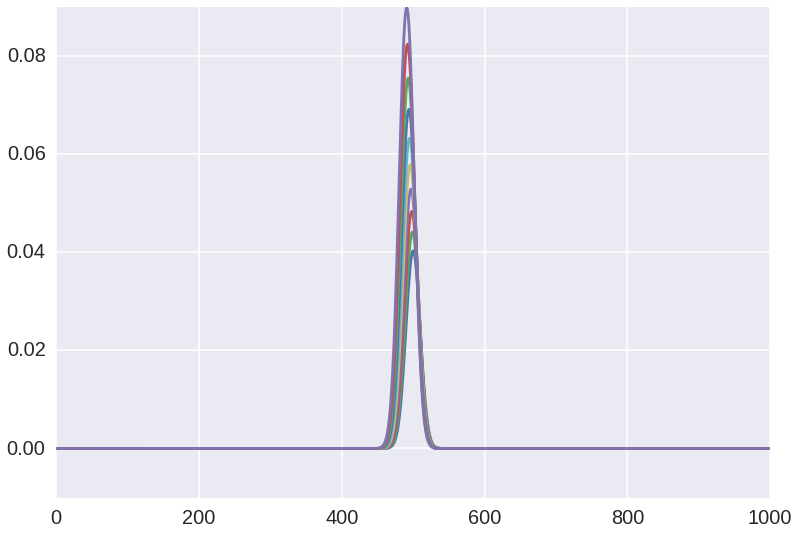

In [35]:
for i in range(0, sol_in_time.shape[1], 10):
    plt.plot(xgrid, sol_in_time[:, i])